## Libraries and functions

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math

In [2]:
#functions
def theSum(aList):
    s = 0 
    for x in aList:
       if x > 0:
           s += x
    return s

def theCount(aList,value):
    c = 0 
    for x in aList:
       if x == value:
           c += 1
    return c

def randDemand(ad,sd):
    d = -1
    while d<0 or d>25:
        d = int(round((0.5 + np.random.lognormal(ad,sd)),0))
    
    return d

## Parameters

In [ ]:
ad = 4.97 #average daily demand
sd = 5.36
Q = 64 # Order Quantity (Full truck load) for Slow Shipping
Qn = 35 #capacidad normal
Qf = 12 #capacidad fast
ss = int(round(ad * 2,0)) #Security Stock
lt_s = 5 #lead time for slow shipping
R =  lt_s*ad + ss #re-order point
lt_n = 3 #lead time for normal shipping
lt_f = 1 #lead time for fast shipping
dw_p = [.7, .2, .1] #probability for delivery windows of 1, 3 and 5 days, respectively

## Simulation

In [3]:
#Simulation code

results = []
results2 = []
total_results =[]
for instances in range(100):
    inventory = Q + ss #initialize inventory
    T = -1 #initialize lead time for slow shipping, it is -1 when there is no slow incoming shipping
    po = [[0 for p in range(1)] for t in range(2)] #Number of incoming orders using normal and/or fast shipping
    po_a = [[-1 for p in range(1)] for t in range(2)] # of days remaining for incoming orders to arrive using normal and/or fast shipping
    orders = [0 for t in range(6)] #orders to be delivered before day t
    em = [0 for i in range(3)] #emissions per type of shippment 
    con_t = [0 for i in range(3)] # contador times type of shippment ordered
    con_o = [0 for i in range(3)] # contador units  type of shippment ordered
    total_demand = 0
    np.random.seed(instances)
    
    #for days in range(30):
    for days in range(87):
       
    #validate incoming orders
        if T > 0: #slow orders update delivery date and inventory
            T -= 1
            if T == 0:
                inventory += Q
                T = -1
        
        #update delivery dates normal and fast shipping
        for o in range(len(po[0])): #normal incoming shippings
            if po[0][o] > 0:
                po_a[0][o] -= 1        
        if po[1][0] > 0: #fast incoming shippings
            po_a[1][0] -= 1
                
        #update inventory and lists  for normal and fast shipping      
        if po_a[0][0] == 0: #normal shipping
            inventory += po[0][0]
            if len(po[0]) == 1:
                po[0][0] = 0
                po_a[0][0] = -1 # -1 means there is no incoming order placed
            else:
                for o in range(len(po[0])-1):
                    #print(po[0], o, o+1, len(po[0]))
                    po[0][o] = po[0][o+1]
                    po_a[0][o] = po_a[0][o+1]
                po[0].pop() #pop remove last element of the list
                po_a[0].pop()

                
        
        if po_a[1][0] == 0: #fast shipping
            inventory += po[1][0]
            po[1][0] = 0
            po_a[1][0] = -1 # -1 means there is no fast order placed
 
        
    #generate demand and allocate it to diferent delivery windows
        demand = randDemand(ad,sd)
        orders[1] += int(round(demand*dw_p[0],0))
        orders[3] += int(round(demand*dw_p[1],0))
        orders[5] += int(round(demand*dw_p[2],0))
        total_demand += int(demand)
        
        #inventory balance
        inventory -= orders[0] #remove from inventory orders to be delivery today
        
        for t in range(5): #send also pending orders if there is stock
            if inventory > 0:
                if inventory > orders[1+t]:
                    inventory -= orders[1+t]
                    orders[1+t] = 0
                else:
                    inventory = 0
                    orders[1+t] -= inventory
        
    #place new incomming shippings according to demand, inventory and/or phantom inventory
        p_inventory = 0 #phantom inventory
        p_demand = 0 # pending demand
        
        #slow shipping - evaluation of extisting order
        if inventory <= R and T == -1: 
            T = lt_s
            em[0] += 2.621*61.9*0.276
            #(61.9 km is the distance) and CE = 2.621 CO2/liter
            con_t[0] += 1
            con_o[0] += Q
        
        #normal shipping - evaluation of next 3 days         
        if T < 3 and T>-1: #slow shipping phatom inventory
            p_inventory += Q
        
        for o in range(len(po[0])): #normal shipping phantom inventory
            if po_a[0][o]<3:
                p_inventory += po[0][o]
        
        for d in range(3):
            p_demand += orders[d+1] 
        if inventory + p_inventory - p_demand - 3*ad*(dw_p[0]+dw_p[1]) <= ss: # balance includeing expecting demand in 2 days
            if po_a[0][0] == -1:
                po[0][0] = int(round(ss - (inventory + p_inventory - p_demand - 3*ad),0))
                po_a[0][0] = 3
                p_inventory += po[0][0]
                em[1] += 2.621*61.9*0.276*math.ceil(po[0][0]/Qn)*(0.227 + 0.049*po[0][0]/(Q*math.ceil(po[0][0]/Qn)))
                con_t[1] += 1
                con_o[1] += po[0][0]
            else:
                order_size = int(round(ss - (inventory + p_inventory - p_demand - 3*ad),0))
                po[0].append(order_size)
                po_a[0].append(3)
                p_inventory += order_size
                em[1] += 2.621*61.9*0.276*math.ceil(order_size/Qn)*(0.227 + 0.049*order_size/(Q*math.ceil(order_size/Qn)))
                con_t[1] += 1
                con_o[1] += order_size
        
        #fast shipping - evaluation of next day         
        p_inventory = 0 #phantom inventory
        p_demand = orders[1] # pending demand
        
        if T == 1: 
            p_inventory += Q
        
        for o in range(len(po[0])): #normal shipping phantom inventory
            if po_a[0][o] == 1:
                p_inventory += po[0][o]
        if inventory + p_inventory - p_demand - ad*dw_p[0] <= ss: # balance includeing expecting demand to be delivered next day
            po_a[1][0] = 1
            order_size = int(round(ss - (inventory + p_inventory - p_demand - ad),0))
            po[1][0] = order_size
            em[2] += 2.621*61.9*0.276*math.ceil(order_size/Qf)*(0.227 + 0.049*order_size/(Q*math.ceil(order_size/Qf)))
            con_t[2] += 1
            con_o[2] += order_size
       
    
        #export results
        results.append([instances+1,days+1,demand, theSum(orders), inventory, Q*(T==5), theSum(po[0]), theCount(po_a[0],3), theSum(po[1]), theCount(po_a[1],1)])
        results2.append([instances+1,days+1,demand, orders, inventory, T, po[0], po_a[0], po[1], po_a[1]])
        
        #pending demand update for next day
        for t in range(5):
            orders[t] = orders[t+1]
        orders[5] = 0
    total_results.append([instances, total_demand,em[0]+em[1]+em[2], con_t[0],con_o[0],em[0], con_t[1],con_o[1],em[1],con_t[2],con_o[2],em[2]])       
        

### Show Results

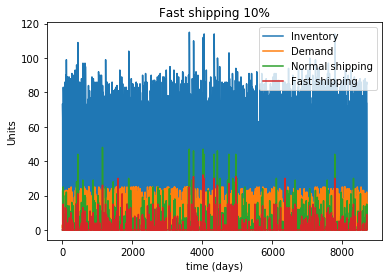

In [134]:
#Units per day
df = pd.DataFrame(results, columns =['Instance', 'Day', 'Demand', 'Orders', 'Inventory', 'T', 'Normal Orders', 'Normal days', 'Fast orders', 'Fast days'])
plt.plot(df['Inventory'],label="Inventory")
plt.plot(df['Demand'], label="Demand")
plt.plot(df['Normal Orders'], label="Normal shipping")
plt.plot(df['Fast orders'], label="Fast shipping")
plt.ylabel('Units')
plt.xlabel('time (days)')
plt.title ('Fast shipping 10%')
plt.legend()
plt.show()

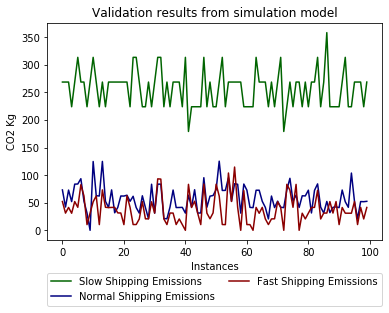

In [136]:
#CO2 emmissions
df = pd.DataFrame(total_results, columns =['Instance', 'Demand', 'Total Emissions', 'Slow Times', 'Slow Units', 'Slow Emissions', 'Normal Times', 'Normal Units', 'Normal Emissions', 'Fast Times', 'Fast Units', 'Fast Emissions'])
df.to_excel("Results Total v5- Base.xlsx",index=False)
plt.plot(df['Slow Emissions'], label="Slow Shipping Emissions", color='darkgreen')
plt.plot(df['Normal Emissions'], label="Normal Shipping Emissions", color='navy')
plt.plot(df['Fast Emissions'], label="Fast Shipping Emissions", color='darkred')
plt.ylabel('CO2 Kg')
plt.xlabel('Instances')
plt.title ('Validation results from simulation model')
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
plt.show()